In [24]:
"""

------------------------
Last Updated: 18/01/2021
------------------------

------------------------------------
THIS NOTEBOOK NEEDS TO BE ORGANIZED 
-----------------------------------


The purpose of this notebook is to get a idea of how the translation of the smiles to 
the coarse-grained beads of Martini can work. 

-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability

-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
 
-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file 

-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk

-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks 

-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/

-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/5776-mapping-of-benzene-ring

-> https://docs.mdanalysis.org/1.0.0/documentation_pages/lib/NeighborSearch.html

-> https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d

-> https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html

-> https://nanotube.msu.edu/fullerene/fullerene-isomers.html

-> https://towardsdatascience.com/molecular-visualization-in-streamlit-using-rdkit-and-py3dmol-part-2-657d28152753

-> https://plotly.com/python/3d-scatter-plots/

Quote by Riccardo: 
------------------

In the open beta of Martini 3, benzene is indeed mapped with three TC4 beads, that that's again a 2-to-1 mapping. 
The bond length is changed to 0.29 nm in 3.0 because this allows to represent more closely the volume of a benzene 
molecule, taking into account also the smaller size of T-beads as compared to S -beads


---------------------------
How the modules are divided
---------------------------

-> We want to be given free reign into making NPs of multiple types. The primary types we are concerned with at the 
   moment is 

   1. Functionalized AuNP type ones.  
   2. Carbon Nanotube like ones. 
   3. Large spherical buckyball type structures - Like C70. 

-> TODO 
    
   - Am not able to get the box dimenisons correct for the xyz file...
   - Need to write Striped/Janus functionality to the NP maker  


Trying to translate the atomic C70 structure into the coarse-grained c70 structure 

TODO - isolate per 2 beads - There is a two to one mapping, and find the center of mass 
       for each of these beads. Then construct the itp file for the bead. 

"""

"\n\n------------------------\nLast Updated: 18/01/2021\n------------------------\n\n------------------------------------\nTHIS NOTEBOOK NEEDS TO BE ORGANIZED \n-----------------------------------\n\n\nThe purpose of this notebook is to get a idea of how the translation of the smiles to \nthe coarse-grained beads of Martini can work. \n\n-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability\n\n-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors\n \n-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file \n\n-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk\n\n-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks \n\n-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/\n\n-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/577

In [25]:
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math 

# Rdkit libraries 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                    
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig  

# Alignment libraries in MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small, PDB, XTC

# Scipy libraries
import scipy                                                                                                                                                                                                                                                                                                                                                                                                          
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from scipy.linalg import solve
from scipy.spatial import distance

# Matplotlib libraries 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

# Pandas 
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import math 
from operator import itemgetter
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random               
        
import plotly.express as px

pd.set_option('display.max_colwidth', None)

IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [18]:
"""
RDKIT functions
"""
def GetRingSystems(mol, includeSpiro=False):
    """
    What is this function doing?
    """
    ri = mol.GetRingInfo() # Sets out the indices of the rings structures within the mol file 
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems
#mol = Chem.MolFromSmiles('CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3')

"""
Plotting functions 
"""

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""
    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()
    

def fibonacci_sphere(samples=1):
    """
    Return a Fibanocci sphere with N number of points on the surface. 
    This will act as the template for the nanoparticle core. 
    """
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

def rotation_matrix_from_vectors(vec1, vec2):
    """ 
    Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def GenerateCore(Radius, N):
    """
    Description 
    -----------
    
    
    
    Parameters
    ----------
    Radius: 
        path and file where the pdb file is.
    N: 
        Placeholder 
        
    Creates a Fibanocci sphere that represents the NP core 
    and Allocates the radius. Using the radius, the core is scaled down/up 
    to the size that one wishes to have. 
    
    """
    Sphere = fibonacci_sphere(N) # Create the fibanocci sphere representing the NP core 
    XSphere, YSphere, ZSphere  = [], [], []
    for entry in Sphere:
        XSphere.append(entry[0])
        YSphere.append(entry[1])
        ZSphere.append(entry[2])
    # Append as 2d list
    SphereList = [] 
    for index in range(0, len(XSphere)):
        SphereList.append([XSphere[index], YSphere[index], ZSphere[index]])
    # Take the radius value, and then multiply the unit vector in each 
    # Direction by that radius value to increase the total volume of the 
    # NP core.
    for index in range(0, len(SphereList) -1):
        SphereList[index][0] = SphereList[index][0] * Radius
        SphereList[index][1] = SphereList[index][1] * Radius
        SphereList[index][2] = SphereList[index][2] * Radius
    return SphereList

def AttachLigands(LigandSmilesString, FirstAtomList, LastAtomList, Core):
    """
    Description
    -----------
    
    
    
    Parameters
    ----------
    LigandSmilesString: 
        path and file where the pdb file is.
    FirstAtomList:
        Placeholder
    LastAtomList: 
        Placeholder
    Core:
        Placeholder 
    """
    # Through MDAnalysis 
    u = mda.Universe.from_smiles(LigandSmilesString)
    Molecule = u.select_atoms('all')
    # Select Atom attached to the core 
    FirstAtom = u.select_atoms('name {}'.format(FirstAtomList[0])) # Pick out the atoms attached
    # Select end atom on the ligand 
    LastAtom = u.select_atoms('name {}'.format(LastAtomList[0])) # Pick out the last atom at the tip of the ligand 
    TransformationList, NameList = [], []
    # Find the vector representing the direction from the sulfur to the tip of the ligand. 
    LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0]  
 
    for i,j in enumerate(Molecule.positions):
        vector = (j - FirstAtom.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Molecule.atoms[i].type])        

    LigandList = [] 
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []

    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        vecMultiplier = vec1_rot/unitVectorabs * 3 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        # TODO
        Sphere.append(vec1_rot.tolist())
        #LigandList.append(vec1_rot.tolist())
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule]
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = 'Ligand'
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = 'Core'
    Total = dfLigand.append(dfCore)
    return Total

def ComputeC70Distances(coordinate):
    """    
    Parameters
    ----------
    coordinate: 
        path and file where the pdb file is.
    
    """
    u = mda.Universe(coordinate)
    
    CorePositions, CoreIndex = [], []
    C70CGBeadPositions = []
    DistanceDict = {}
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # iterate through items 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions:
            # Find the distance between the index atoms in the index, atom.. 
            # and the core 
            dist = distance.euclidean(items[1], atoms.position)
            Entry = [index, items[0], dist]
            # Sort entry by dist 
            DistanceDict[index].append(Entry)
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    # Sort each entry by distance 
    
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # 
        ClosestAtomsDistance.append(DistanceDict[key][1])
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    # Take the indices in the unique data and compute the averge coordinates
    
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
    return C70CGBeadPositions


def GenerateXYZ(NPDataframe):
    """
    Parameters
    ----------
    Generate xyz structure coordinates from 
    the made NP. 
    """
    with open("file.xyz", 'w') as xyz_file:
        xyz_file.write("%d\n%s\n" % (len(NPDataframe), 'NP'))
        for index, row in NPDataframe.iterrows():
            xyz_file.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format(
                row['NAME'], row['X'], row['Y'], row['Z']))
    
def mol_with_atom_index(mol):
    """
    
    """
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol



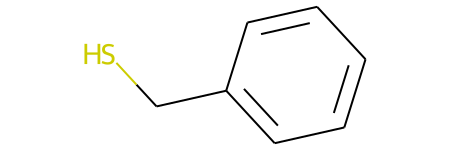

In [8]:
""" 
Annotating and drawing an example sulfur ligand 
"""
u1 = mda.Universe.from_smiles("C1=C(C=CC=C1)CS[H]")
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
#mol_with_atom_index(m_aromatic)
m_aromatic

In [9]:
""" 
Working on the same ligand.. 
"""
# Through RDKIT
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
mol_with_atom_index(m_aromatic)

# Through MDAnalysis 
u1 = mda.Universe.from_smiles(AromaticSulfurSmilesString)
Molecule = u1.select_atoms('all')
Molecule.positions # Finds the cartesian coordinates of the ligands 

array([[-0.26610637,  1.1070386 , -0.46959504],
       [ 0.501186  , -0.02841815, -0.3253443 ],
       [-0.0890135 , -1.1853931 ,  0.16173992],
       [-1.409722  , -1.2068603 ,  0.49543637],
       [-2.1432908 , -0.05113159,  0.33685663],
       [-1.6199689 ,  1.1257848 , -0.13952287],
       [ 1.9393263 ,  0.02000745, -0.69610053],
       [ 2.975364  ,  0.50240093,  0.7004398 ],
       [ 0.15080966,  2.0363896 , -0.8466707 ],
       [ 0.56207937, -2.0490208 ,  0.25471938],
       [-1.8245246 , -2.1363595 ,  0.8720472 ],
       [-3.1944468 , -0.10784676,  0.614092  ],
       [-2.2026258 ,  2.0348861 , -0.2628603 ],
       [ 2.252984  , -1.0099901 , -1.0048219 ],
       [ 2.0847242 ,  0.7267021 , -1.5605043 ],
       [ 2.283225  ,  0.22181058,  1.8700887 ]], dtype=float32)

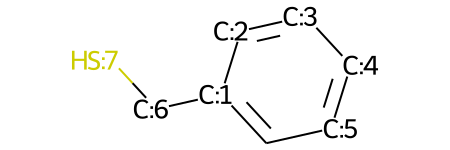

In [10]:
m_aromatic

In [5]:
C70 = mda.Universe.from_smiles("c1(c2c3c4c15)c6c7c8c2c9c%10c3c%11c%12c4c%13c%14c5c%15c6c%16c7c%17c%18c%19c%20c%21c%22c%23c%24c%21c%25c%26c%20c%18c%16c%27c%15c%14c%28c(c%25c%29c%24c%30c%31c%23c%32c%33c%22c%19c%34c%33c(c9c8c%34%17)c%35c%10c%11c(c%31c%32%35)c%36c%12c%13c%28c%29c%30%36)c%26%27")

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:161: UserWarning: No coordinates found in the RDKit molecule
  warnings.warn("No coordinates found in the RDKit molecule")


In [6]:
C70.atoms

<AtomGroup with 70 atoms>

In [83]:
# Highlight a Substructure in a Molecule - Can we identify the benzene part and sulfur part?

ConvertedSmiles = Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1'))
ConvertedSmiles

ExampleMartiniString = "CC(=O)CO" # Example smiles string that is compatible with MARTINI 
ConvertedSmiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(ExampleMartiniString))
ConvertedSmiles2
m2  = Chem.MolFromSmiles(ConvertedSmiles2)
#m2
# Hence, we need to create a dictionary that catalogues the string with the relevant martini bead 
SmilesToMartiniDictionary = {}
SmilesToMartiniDictionary["CC(=O)CO"] = 'P2' # P2 Bead 
SmilesToMartiniDictionary["CC(=O)O"] = 'SP2' # SP2 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 

In [13]:
"""
This part links the lignad coordinates with the 
"""
# new feature
u1 = mda.Universe.from_smiles("c1ncncc1C(=O)[O-]")
# new feature
Molecule = u1.select_atoms('all')
Molecule.positions # Finds 
# Need to label each of the xyz coordinates with the relevant indices within the 

array([[-0.22472751, -1.1280737 ,  0.19541302],
       [-1.5704545 , -1.023252  ,  0.20934   ],
       [-2.1961048 ,  0.15957293,  0.02464339],
       [-1.4453826 ,  1.2551624 , -0.17765924],
       [-0.08878438,  1.1825782 , -0.19727382],
       [ 0.56562644, -0.01720943, -0.01039633],
       [ 2.0195458 , -0.12108581, -0.02697152],
       [ 2.7724788 ,  0.8622499 , -0.21044609],
       [ 2.6224356 , -1.3553001 ,  0.1670108 ],
       [ 0.29183823, -2.069239  ,  0.3419321 ],
       [-3.2804613 ,  0.1926303 ,  0.04453019],
       [ 0.53399026,  2.0619664 , -0.36012247]], dtype=float32)

In [14]:
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
substructure = Chem.MolFromSmarts('CC(=O)O')
print(m.GetSubstructMatches(substructure)) # Shows the indices of the molcule that matches the MARTINI bead 

# Find part of the smiles which is part of a ring 

ri = m.GetRingInfo().AtomRings()
for ring in ri:
    print(ring)

((10, 8, 9, 7),)
(0, 12, 11, 6, 2, 1)


In [86]:
"""
In the above situation, we can identify the 3 parts - the thiolated part, the saturated hydrocarbon chain attached 
to the benzene group, and the benzene group itself. 
"""
substructure = Chem.MolFromSmarts('SC')
print(m.GetSubstructMatches(substructure))

()


In [19]:

def GetRingSystems(mol, includeSpiro=False):
    """
    What is this function doing?
    """
    ri = mol.GetRingInfo() # Sets out the indices of the rings structures within the mol file 
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems


mol = Chem.MolFromSmiles('CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3')
#print(GetRingSystems(mol))
#mol

Molecule.positions
Molecule.atoms.write("mol.pdb")

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning:

Unit cell dimensions not found. CRYST1 record set to unitary values.

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning:

Found no information for attr: 'altLocs' Using default value of ' '

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning:

Found no information for attr: 'resnames' Using default value of 'UNK'

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning:

Found no information for attr: 'icodes' Using default value of ' '

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning:

Found no information for attr: 'chainIDs' Using default value of ''

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning:

Found no information for attr: 'occupancies' Using default 

In [20]:
vector_plot(GenerateCore(10, 100))

In [21]:
SphereList = GenerateCore(10, 20)
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
PandasNPDataframe = AttachLigands('C1=C(C=CC=C1)CS[H]', ['S7'], ['C4'], SphereList)

In [22]:
PandasNPDataframe

,X,Y,Z,NAME,name
0,3.617648e-01,11.472312,1.353317e+00,C0,Ligand
1,-6.277053e-01,10.805585,6.610541e-01,C1,Ligand
2,-1.293357e+00,11.463001,-3.521248e-01,C2,Ligand
3,-9.884634e-01,12.782929,-6.905060e-01,C3,Ligand
4,3.393670e-15,13.451105,2.857827e-16,C4,Ligand
...,...,...,...,...,...
15,-5.475496e-01,-3.025320,-4.225403e+00,Au,Core
16,2.914012e+00,-3.575378,2.455932e+00,Au,Core
17,-3.204624e+00,-4.125436,1.325213e-01,Au,Core
18,1.654195e+00,-4.675494,-1.646145e+00,Au,Core


In [26]:

fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [27]:
m = Chem.MolFromMolFile('c70.mol') # Read in the C70 mol 
mol1 = u1.atoms.convert_to("RDKIT") # Convert to rdkit 
u = mda.Universe('c70.pdb') # 
mol1 = u.atoms.convert_to("RDKIT", force=True)

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:368: UserWarning:

No hydrogen atom found in the topology. Forcing to continue the conversion.



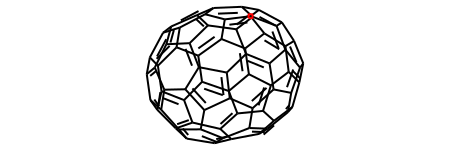

In [29]:
mol1 # we see that the 

In [12]:
u = mda.Universe('c70.pdb')
mol1 = u.atoms.convert_to("RDKIT", force=True)
C70List = [] 
for index, atoms in enumerate(u.atoms):
    C70List.append(list(atoms.position))
C70List

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:368: UserWarning:

No hydrogen atom found in the topology. Forcing to continue the conversion.



[[3.973, 0.535, -0.149],
 [3.773, -0.443, -1.066],
 [3.416, -1.699, -0.675],
 [3.228, 0.101, -2.174],
 [2.317, -0.592, -2.906],
 [3.061, 1.417, -1.949],
 [1.982, 2.069, -2.456],
 [3.503, 1.684, -0.702],
 [2.88, 2.634, 0.051],
 [3.809, 0.316, 1.179],
 [3.357, -0.977, 1.625],
 [2.456, -0.799, 2.613],
 [3.189, -1.963, 0.727],
 [2.151, -2.808, 0.82],
 [2.473, -2.406, -1.323],
 [1.711, -3.074, -0.43],
 [1.915, -1.898, -2.439],
 [0.602, -2.029, -2.674],
 [1.192, -0.021, -3.368],
 [0.159, -0.881, -3.235],
 [0.997, 1.299, -3.18],
 [-0.212, 1.78, -2.857],
 [1.276, 2.95, -1.728],
 [-0.042, 2.787, -1.971],
 [1.7, 3.271, -0.491],
 [0.827, 3.43, 0.515],
 [2.607, 2.453, 1.353],
 [1.383, 2.918, 1.635],
 [3.057, 1.237, 1.986],
 [2.247, 0.532, 2.804],
 [0.543, 2.281, 2.647],
 [1.047, 1.019, 3.244],
 [-3.627, 0.321, 2.123],
 [-4.038, -0.018, 0.876],
 [-3.878, 0.843, -0.169],
 [-3.851, -1.344, 0.7],
 [-3.5, -1.84, -0.517],
 [-3.299, -1.838, 1.826],
 [-2.39, -2.848, 1.764],
 [-3.141, -0.813, 2.693],
 [-2.

In [41]:
def ConvertC70Core(coordinate):
    """    
    Description 
    -----------
    
    Creates a MDAnalysis universe from the pdb input of the C70 file, and 
    creates a coarse-grained framework of the C70. 
    
    
    Parameters
    ----------
    coordinate: 
        path and file where the pdb file is.
    filename : str
    copy : bool
    dtype : data-type
    iterable : iterable object
    shape : int or tuple of int
    files : list of str
    
    Returns
    -------
    int
        Description of anonymous integer return value.
    """
    u = mda.Universe(coordinate) # Create Universe 
    CorePositions, CoreIndex = [], [] # Get positions and indices of the core 
    C70CGBeadPositions = [] # list to append the new 'coarse-grained' positions of the C70 Martini NP
    DistanceDict = {} 
    
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # loop over the indices and atoms within the universe 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions: # each element here is [index, atom.position]
            Distance = distance.euclidean(items[1], atoms.position) # get the distance between the atoms and the core
            Entry = [index, items[0], Distance] # index of position A and index of position B, and the distance between 
            DistanceDict[index].append(Entry) # Append this list 
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    
    # Sort each entry by distance 
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # Get first two index 
        ClosestAtomsDistance.append(DistanceDict[key][1]) 
    
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    
    # Take the indices in the unique data and compute the averge coordinates
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
        
    return C70CGBeadPositions

def ConstructNPNetwork():
    """
    """
    pass



In [42]:
NPPositions = ConvertC70Core('c70.pdb')
NPPositions

[array([ 0.39249998,  1.5395    , -3.0185    ], dtype=float32),
 array([-3.22  , -1.3255,  2.2595], dtype=float32),
 array([ 2.67      , -2.3855    ,  0.77349997], dtype=float32),
 array([-2.4299998,  1.8634999, -1.5074999], dtype=float32),
 array([-1.606,  0.954,  3.481], dtype=float32),
 array([-3.0265    , -2.316     , -0.58150005], dtype=float32),
 array([ 0.67550004, -0.451     , -3.3014998 ], dtype=float32),
 array([-0.352 , -3.4235,  1.117 ], dtype=float32),
 array([ 1.7544999 , -0.30650002, -3.137     ], dtype=float32),
 array([-3.3734999, -0.2395   , -1.4844999], dtype=float32),
 array([-3.575    , -1.5910001,  1.263    ], dtype=float32),
 array([ 1.2969999, -2.2680001,  2.3925   ], dtype=float32),
 array([-1.8330001, -2.8455   ,  2.144    ], dtype=float32),
 array([-3.9445, -0.681 ,  0.788 ], dtype=float32),
 array([-1.1865,  2.7435,  2.0095], dtype=float32),
 array([ 3.273, -1.47 ,  1.176], dtype=float32),
 array([ 3.5005    , -0.17099999, -1.62      ], dtype=float32),
 arra

In [43]:
"""
Plotting the new C70 core and plotting the 3D scatter plot to see what it looks like
"""
df = pd.DataFrame(NPPositions, columns = ['X','Y','Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

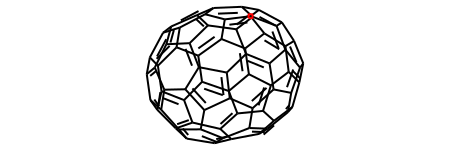

In [15]:
mol1 # Nice..  

In [36]:
"""
The smiles for the ligand 

Links on information about the C60/C70 ligand bonded NP
-------------------------------------------------------

poly(3-hexyl-thiophene) (P3HT)

phenyl-C-61-butyric acid methyl ester (PCBM).

https://pubchem.ncbi.nlm.nih.gov/compound/3-Hexylthiophene

https://pubchem.ncbi.nlm.nih.gov/compound/6_6_-Phenyl-C61-butyric-acid-methyl-ester

https://chemrxiv.org/engage/chemrxiv/article-details/60c74b9abb8c1a44713db259

https://research.rug.nl/en/publications/resolving-donor-acceptor-interfaces-and-charge-carrier-energy-lev

https://www.americanelements.com/60-pcbm-6-6-phenyl-c61-butyric-acid-methyl-ester-160848-22-6

http://www-jmg.ch.cam.ac.uk/data/molecules/misc/c70.html
 
https://en.wikipedia.org/wiki/Phenyl-C61-butyric_acid_methyl_ester - information on its application
as potential solar cells 

"""


# Which ligand do I need to attach by? 


P3HT = 'CCCCCCC1=CSC=C1'
m_P3HT = Chem.MolFromSmiles(P3HT)
# Universe 
u_P3HT = mda.Universe.from_smiles(P3HT)
# Need to add index 
u_P3HT_object = u_P3HT.select_atoms('all')
#mol_with_atom_index(m_aromatic)


# Select Atom attached to the core 
FirstAtom = u.select_atoms('name {}'.format(FirstAtomList[0])) # Pick out the atoms attached
# Select end atom on the ligand 
LastAtom = u.select_atoms('name {}'.format(LastAtomList[0])) # Pick out the last atom at the tip of the ligand 
TransformationList, NameList = [], []
# Find the vector representing the direction from the sulfur to the tip of the ligand. 
LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0

In [44]:
u_P3HT

<Universe with 27 atoms>

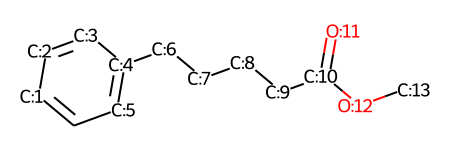

In [38]:
# C70
Phenyl_C61_Butyric_Acid_Methyl_Ester = 'C1=CC=CC(=C1)CCCCC(=O)OC'
C70BAME = Chem.MolFromSmiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
u_C70BAME = mda.Universe.from_smiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
# Need to add index 
u_C70BAME_object = u_C70BAME.select_atoms('all')
#u_C70BAME_object.write("u_C70BAME.xyz")
mol_with_atom_index(C70BAME) # C6 is the attaching ligand 

In [ ]:
# https://stackoverflow.com/questions/53075481/how-do-i-cluster-a-list-of-geographic-points-by-distance


import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

points = np.array([[33.    , 41.    ],
       [33.9693, 41.3923],
       [33.6074, 41.277 ],
       [34.4823, 41.919 ],
       [34.3702, 41.1424],
       [34.3931, 41.078 ],
       [34.2377, 41.0576],
       [34.2395, 41.0211],
       [34.4443, 41.3499],
       [34.3812, 40.9793]])


def distance(origin, destination): #found here https://gist.github.com/rochacbruno/2883505
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def create_clusters(number_of_clusters,points):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(points)
    l_array = np.array([[label] for label in kmeans.labels_])
    clusters = np.append(points,l_array,axis=1)
    return clusters

def validate_solution(max_dist,clusters):
    _, __, n_clust = clusters.max(axis=0)
    n_clust = int(n_clust)
    for i in range(n_clust):
        two_d_cluster=clusters[clusters[:,2] == i][:,np.array([True, True, False])]
        if not validate_cluster(max_dist,two_d_cluster):
            return False
        else:
            continue
    return True

def validate_cluster(max_dist,cluster):
    distances = cdist(cluster,cluster, lambda ori,des: int(round(distance(ori,des))))
    print(distances)
    print(30*'-')
    for item in distances.flatten():
        if item > max_dist:
            return False
    return True

if __name__ == '__main__':
    for i in range(2,len(points)):
        print(i)
        print(validate_solution(20,create_clusters(i,points)))


In [96]:
DistIndex1Index2
UniqueIndex1Index2Distances = [list(i) for i in list(set(map(tuple, DistIndex1Index2)))]

NameError: name 'DistIndex1Index2' is not defined

In [133]:
import os                                                                                                                                                                                                  
import numpy as np                                                                                                                                                                                         
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random                                                                                                                                                                                              
                                                                                                                                                                                                           
# RDKit libaries                                                                                                                                                                                           
from rdkit import Chem                                                                                                                                                                                     
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                    
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig                                                                                                                                                                                 
                                                                                                                                                                                                           
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math                                                                                                                                                                                                
import scipy                                                                                                                                                                                               
                                                                                                                                                                                                           
# scipy libaries                                                                                                                                                                                           
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d           

def read_DG_data(DGfile):                                                                                                                                                                                  
    # Reads Delta G_OW for fragments into dictionary                                                                                                                                                       
    DG_data = {}                                                                                                                                                                                           
    with open(DGfile) as f:                                                                                                                                                                                
        for line in f:                                                                                                                                                                                     
            (key,val) = line.rstrip().split()                                                                                                                                                              
            DG_data[key] = float(val)                                                                                                                                                                      
                                                                                                                                                                                                           
    return DG_data                                                                                                                                                                                         
                                                                                                                                                                                                           
def include_weights(A,w):                                                                                                                                                                                  
    # Weights atoms by setting diagonal components                                                                                                                                                         
    A_weighted = np.copy(A)                                                                                                                                                                                
    for i,weight in enumerate(w):                                                                                                                                                                          
        A_weighted[i,i] = weight     
        
def get_smarts_matches(mol):                                                                                                                                                                               
    #Get matches to SMARTS strings                                                                                                                                                                         
    smarts_strings = {                                                                                                                                                                                     
    'S([O-])(=O)(=O)O'  :    'Qa',                                                                                                                                                                         
    'S([O-])(=O)(=O)[C;!$(*F)]'   :    'Q0'}                                                                                                                                                               
    matched_maps = []                                                                                                                                                                                      
    matched_beads = []                                                                                                                                                                                     
    for smarts in smarts_strings:                                                                                                                                                                          
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))                                                                                                                                      
        for match in matches:                                                                                                                                                                              
            matched_maps.append(list(match))                                                                                                                                                               
            matched_beads.append(smarts_strings[smarts])                                                                                                                                                   
                                                                                                                                                                                                           
    return matched_maps,matched_beads           

In [130]:
DataPath = '/home/sang/Desktop/GIT/MDNPPackage/temp/cgparam/fragment_DGs.dat'

In [131]:
read_DG_data(DataPath)

{'CC': 8.2656,
 'CN': -6.0844,
 'CO': -7.9212,
 'CF': 2.3534,
 'CCl': 3.8458,
 'C=C': 5.166,
 'C=O': -3.9032,
 'C#C': -0.1722,
 'CCC': 12.5706,
 'CCN': -1.148,
 'CCO': -2.296,
 'CCF': 5.7974,
 'CCCl': 8.4378,
 'FCF': 1.6646,
 'FCCl': 3.5588,
 'ClCF': 3.5588,
 'ClCCl': 6.4288,
 'CNC': -3.0422,
 'COC': -0.9184,
 'CC=C': 9.6432,
 'CC=O': -0.0574,
 'CC#N': -0.2296,
 'NC=N': -8.036,
 'NC=O': -8.7822,
 'OC=O': -2.6978,
 'FC=C': 5.8548,
 'ClC=C': 8.2082,
 'NN=C': -1.8368,
 'ON=C': -1.7794,
 'CC#C': 5.2808,
 'CC(C)C': 12.3984,
 'CC(C)N': -0.287,
 'CC(C)O': 0.2296,
 'CC(C)F': 6.1992,
 'CC(C)Cl': 8.5526,
 'CC(F)F': 4.5346,
 'CC(F)Cl': 7.2898,
 'CC(Cl)F': 7.2898,
 'CC(Cl)Cl': 9.8728,
 'FC(F)F': 5.5678,
 'FC(F)Cl': 5.6252,
 'FC(Cl)F': 5.6252,
 'FC(Cl)Cl': 7.3472,
 'ClC(F)F': 5.6252,
 'ClC(F)Cl': 7.3472,
 'ClC(Cl)F': 7.3472,
 'ClC(Cl)Cl': 9.5858,
 'CN(C)C': -0.8036,
 'CC(C)=C': 10.7338,
 'CC(C)=O': -1.6646,
 'CC(N)=N': -5.74,
 'CC(N)=O': -6.314,
 'CC(O)=O': -0.6888,
 'CC(F)=C': 7.4046,
 'CC(Cl)=C':

In [ ]:
def write_gro(mol_name,bead_types,coords0,gro_name):                                                                                                                                                       
    #write gro file                                                                                                                                                                                        
    conf = mol.GetConformer(0)                                                                                                                                                                             
    with open(gro_name,'w') as gro:                                                                                                                                                                        
        gro.write('single molecule of {}\n'.format(mol_name))                                                                                                                                              
        gro.write('{}\n'.format(len(bead_types)))                                                                                                                                                          
        i = 1                                                                                                                                                                                              
        for bead,xyz in zip(bead_types,coords0):                                                                                                                                                           
            gro.write('{:5d}{:5}{:>5}{:5d}{:8.3f}{:8.3f}{:8.3f}\n'.format(1,mol_name,bead,i,xyz[0],xyz[1],xyz[2]))                                                                                         
            i += 1                                                                                                                                                                                         
        gro.write('5.0 5.0 5.0')         